In [ ]:
!pip install spektral==0.6.0 #feel free to use any other library of your choice
!pip install Keras==2.4.3
!pip install tensorflow==2.2.0

     |████████████████████████████████| 95 kB 1.4 MB/s 
     |████████████████████████████████| 462 kB 33.9 MB/s 
  Attempting uninstall: Keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.4.3 which is incompatible.
     |████████████████████████████████| 516.2 MB 3.6 kB/s 
     |████████████████████████████████| 3.0 MB 39.7 MB/s 
     |████████████████████████████████| 454 kB 53.5 MB/s 
     |████████████████████████████████| 2.9 MB 31.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: te

In [ ]:
import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GraphConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import sys
runningOnColab = 'google.colab' in sys.modules
if runningOnColab:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd '/content/drive/Shareddrives/ECE232E/Project 2'

Mounted at /content/drive
/content/drive/Shareddrives/ECE232E/Project 2


In [ ]:
!tar -xvf "cora.tgz"

cora/
cora/README
cora/cora.cites
cora/cora.content


In [ ]:
all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

                

all_data = shuffle(all_data,random_state=42)

In [ ]:
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] 
F = X.shape[1]
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)


X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Rule_Learning', 'Reinforcement_Learning', 'Neural_Networks', 'Probabilistic_Methods', 'Genetic_Algorithms', 'Theory', 'Case_Based'}

Number of classes:  7


In [ ]:
# Using network x and build a graph 

In [ ]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)


A = nx.adjacency_matrix(G)
print('Graph info: ', nx.info(G))

#use gcc if you want. 

Graph info:  Graph with 2708 nodes and 5278 edges


In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 5.1 MB/s 
     |████████████████████████████████| 482 kB 31.8 MB/s 
     |████████████████████████████████| 41 kB 443 kB/s 


In [ ]:
from stellargraph import StellarGraph 
from stellargraph import datasets

from IPython.display import display, HTML

In [ ]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [ ]:
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

In [ ]:
#get 20 train instances per class
#remaining instances are in test set test   - stratify used to remove class imbalance, 

from sklearn import preprocessing, model_selection

train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [ ]:
# make sure the total is 140 with a balance of the dataset maintained
train_subjects.value_counts()

Neural_Networks           42
Probabilistic_Methods     22
Genetic_Algorithms        22
Theory                    18
Case_Based                16
Reinforcement_Learning    11
Rule_Learning              9
Name: subject, dtype: int64

In [ ]:
# encode the training dataset 


target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [ ]:

generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

## GCN

In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<tf.Tensor 'gather_indices_6/Identity:0' shape=(1, None, 16) dtype=float32>

In [ ]:
predictions = tf.keras.layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 0s - loss: 1.9472 - acc: 0.1786 - val_loss: 1.8978 - val_acc: 0.2200
Epoch 2/200
1/1 - 0s - loss: 1.8917 - acc: 0.2214 - val_loss: 1.8406 - val_acc: 0.2380
Epoch 3/200
1/1 - 0s - loss: 1.8142 - acc: 0.2571 - val_loss: 1.7736 - val_acc: 0.2900
Epoch 4/200
1/1 - 0s - loss: 1.7141 - acc: 0.3214 - val_loss: 1.6986 - val_acc: 0.3520
Epoch 5/200
1/1 - 0s - loss: 1.6413 - acc: 0.3714 - val_loss: 1.6178 - val_acc: 0.4920
Epoch 6/200
1/1 - 0s - loss: 1.5574 - acc: 0.4643 - val_loss: 1.5318 - val_acc: 0.5760
Epoch 7/200
1/1 - 0s - loss: 1.4488 - acc: 0.5357 - val_loss: 1.4468 - val_acc: 0.5600
Epoch 8/200
1/1 - 0s - loss: 1.3656 - acc: 0.5714 - val_loss: 1.3669 - val_acc: 0.5480
Epoch 9/200
1/1 - 0s - loss: 1.2507 - acc: 0.5929 - val_loss: 1.2969 - val_acc: 0.5400
Epoch 10/200
1/1 - 0s - loss: 1.1821 - acc: 0.6000 - val_loss: 1.2336 - val_acc: 0.5500
Epoch 11/200
1/1 - 0s - loss: 1.0978 - acc: 0.6143 - val_loss: 1.1696 - val_acc: 0.5580
Epoch 12/200
1/1 - 0s - loss: 0.9448 - ac

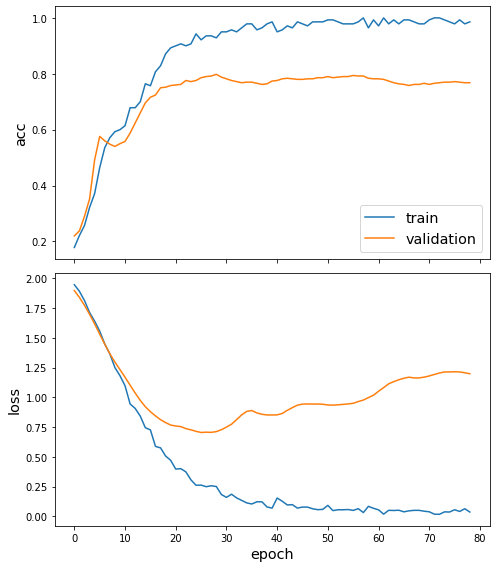

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 3ms/step - loss: 0.6661 - acc: 0.7790

Test Set Metrics:
	loss: 0.6661
	acc: 0.7790


In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [ ]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Theory,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

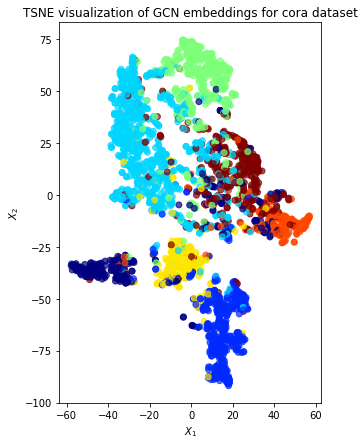

In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_gen)
emb.shape

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

X = emb.squeeze(0)
X.shape

trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)

## Adding more layers to the network 

In [ ]:

generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
gcn = GCN(
    layer_sizes=[32, 64], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<tf.Tensor 'gather_indices_10/Identity:0' shape=(1, None, 64) dtype=float32>

In [ ]:
layer_1= tf.keras.layers.Dense(units=30, activation="relu")(x_out)
# layer_2= tf.keras.layers.Dense(units=30, activation="relu")(layer_1)
layer_3= Dropout(0.4)(layer_1)
predictions = tf.keras.layers.Dense(units=train_targets.shape[1], activation="softmax")(layer_3)


In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=["acc"],
)
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(1, 2708, 1433)]    0                                            
__________________________________________________________________________________________________
input_43 (InputLayer)           [(1, None, 2)]       0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           [(1, None)]          0                                            
__________________________________________________________________________________________________
dropout_31 (Dropout)            (1, 2708, 1433)      0           input_41[0][0]                   
___________________________________________________________________________________________

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)


Epoch 1/200
1/1 - 0s - loss: 1.9427 - acc: 0.1643 - val_loss: 1.8971 - val_acc: 0.3020
Epoch 2/200
1/1 - 0s - loss: 1.8831 - acc: 0.3071 - val_loss: 1.8275 - val_acc: 0.3020
Epoch 3/200
1/1 - 0s - loss: 1.8158 - acc: 0.2857 - val_loss: 1.7500 - val_acc: 0.3020
Epoch 4/200
1/1 - 0s - loss: 1.7326 - acc: 0.3286 - val_loss: 1.6617 - val_acc: 0.3040
Epoch 5/200
1/1 - 0s - loss: 1.5941 - acc: 0.3571 - val_loss: 1.5606 - val_acc: 0.3700
Epoch 6/200
1/1 - 0s - loss: 1.4988 - acc: 0.4214 - val_loss: 1.4574 - val_acc: 0.4500
Epoch 7/200
1/1 - 0s - loss: 1.3556 - acc: 0.5143 - val_loss: 1.3702 - val_acc: 0.4920
Epoch 8/200
1/1 - 0s - loss: 1.2343 - acc: 0.5357 - val_loss: 1.2972 - val_acc: 0.5680
Epoch 9/200
1/1 - 0s - loss: 1.1377 - acc: 0.5500 - val_loss: 1.2428 - val_acc: 0.6540
Epoch 10/200
1/1 - 0s - loss: 1.0264 - acc: 0.6357 - val_loss: 1.2053 - val_acc: 0.7040
Epoch 11/200
1/1 - 0s - loss: 0.9033 - acc: 0.7286 - val_loss: 1.1487 - val_acc: 0.7340
Epoch 12/200
1/1 - 0s - loss: 0.8555 - ac

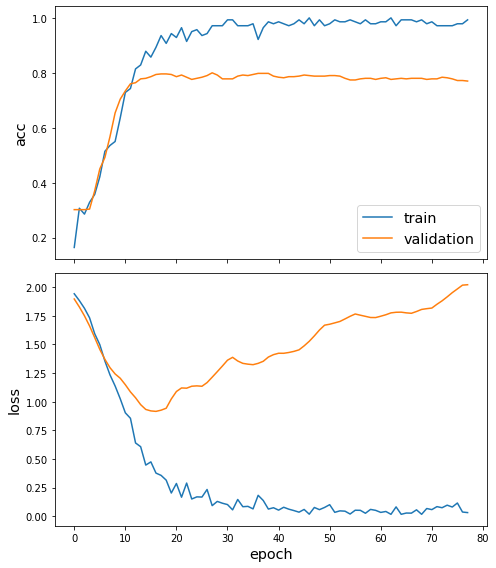

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 2ms/step - loss: 1.1617 - acc: 0.7979

Test Set Metrics:
	loss: 1.1617
	acc: 0.7979


In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [ ]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

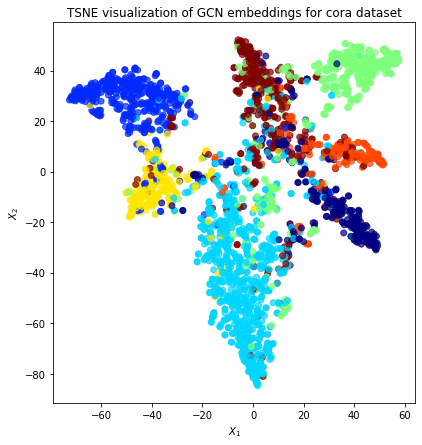

In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_gen)
emb.shape

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

X = emb.squeeze(0)
X.shape

trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)